# Project in Machine Learning Class: Predict user's review sentiment

### John Koumentis, MTN2012

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
!python -m spacy download el_core_news_sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample

import requests
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


## Load and pre-process data

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset
if os.path.exists('20191226-reviews.csv'):
    df = pd.read_csv('20191226-reviews.csv')
else:
    df = pd.read_csv('https://drive.google.com/uc?id=1jwYbSTB4m0LaWKl0UCxcWLiJdLHpsnFX&export=download')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
#reviews_dataset.to_csv('reviews.csv')
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


After removing the lines containing the empty reviews and creating a new dataset by keeping only the reviews and ratings column, the reviews column was loaded in XLSX format at https://translate.google.gr/?hl=el&sl=auto&tl=el&op=docs and translated. The output was an HTML table that was launched via Excel and stored in CSV format with name 'translate.csv'.

In [7]:
if os.path.exists('translated.csv'):
    translated = pd.read_csv('translated.csv',header=None)
else:
    translated = pd.read_csv('https://drive.google.com/uc?id=1Jr4Mvh4V4xtR6_47jIIyJ8N6pebunmni&export=download',
                         header=None)
reviews_dataset.insert(loc=1, column='greek', value=translated)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,3
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,1
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",5
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",3
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,4
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",4
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,5
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",4
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",5
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",3


Introducing a function to clean the translated text, that converts words to lowercase, removes punctuation and stopwords and applies lemmatization.

In [8]:
#Clean reviews text
punctuation = set(string.punctuation)
latin = re.compile(r'[^a-zÀ-ÿ]+') #Locate Latin characters
special_chars = re.compile('[u"\U0001F300-\U0001F5FF"]+',flags=re.UNICODE) #Locate special characters like emojis
nlp = spacy.load('el_core_news_sm')

def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Remove special characters
    text = special_chars.sub(r'',text)
    # Remove Latin characters
    wordList = latin.findall(text)
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punctuation)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('greek')]
    # Lemmatisation
    cleaned_text = nlp(" ".join(wordList))
    cleaned_text = [token.lemma_ for token in cleaned_text]
    return " ".join(cleaned_text)

Due to long execution time the results of the following cell execution were stored in the cleaned.csv file, to get retrieved directly from there.

In [9]:
#start = time.process_time()
#reviews_dataset['cleaned_text'] = reviews_dataset['greek'].apply(clean_text)
#print(time.process_time() - start)
#reviews_dataset.to_csv('cleaned.csv')
if os.path.exists('cleaned.csv'):
    reviews_dataset = pd.read_csv('cleaned.csv')
else:
    reviews_dataset = pd.read_csv('https://drive.google.com/uc?id=1I9_zVYFblWO4uYP3-WsIkV-RPdsUMx2o&export=download',
                              index_col=0)

C:\Users\John\Anaconda3\envs\MLtask\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ratings', ylabel='count'>

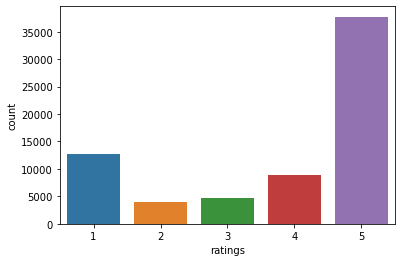

In [10]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

The `4` and `5` star (positive) ratings combined are more than the `1`,`2` ones (negative) combined. Hence, I decided to add the `3` star ratings to the negative ratings. In order to simplify the situation, I replaced the `4`,`5` star ratings with the label `1`, to indicate positive sentiment and the `1`,`2`,`3` star ratings with the label `0`, to indicate negative sentiment.

In [11]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
reviews_dataset.head(10)

,Unnamed: 0,reviews,greek,ratings,cleaned_text
0,0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,0,έχω το 600 για λίγο που είναι απόλυτος ...
1,1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,0,λόγω ενός προβλήματος λογισμικός μεταξύ της ...
2,2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",1,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...
3,3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",0,λατρεύω το τηλέφωνος και όλος γιατί πραγματικά...
4,4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,1,το τηλέφωνος ήταν τέλειος για κάθε σκοπό που π...
5,5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",1,γειο σας έχω αυτό το τηλέφωνος και το χρησιμοπ...
6,6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,1,δροσερός φτηνό χρώμα 3 λέξει που περιγράφω τέλ...
7,7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",1,το 3599 είναι γενικά ένα ωραίος τηλέφωνο εκτ...
8,8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",1,δεν έχω ποτέ προηγουμένως τηλέφωνος γι ' αυ...
9,9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",0,εντάξω είμαι στο σχολείο και χρειάζομαι τα γρα...


C:\Users\John\Anaconda3\envs\MLtask\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ratings', ylabel='count'>

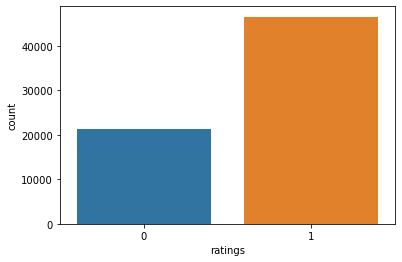

In [12]:
sns.countplot(reviews_dataset['ratings'])

After cleaning the data, there were some reviews that provided empty result:

In [13]:
missing_data = reviews_dataset.isnull().sum()
print(missing_data)

Unnamed: 0        0
reviews           0
greek             0
ratings           0
cleaned_text    285
dtype: int64


In [14]:
nans = np.where(pd.isnull(reviews_dataset.cleaned_text))
reviews_dataset.drop(list(nans)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [15]:
#Isolate cleaned text and ratings columns in a new dataset
reviews = pd.DataFrame({'reviews':reviews_dataset.cleaned_text.values, 'ratings':reviews_dataset.ratings.values})
#reviews_dataset.to_csv('reviews.csv')
reviews.head()

,reviews,ratings
0,έχω το 600 για λίγο που είναι απόλυτος ...,0
1,λόγω ενός προβλήματος λογισμικός μεταξύ της ...,0
2,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...,1
3,λατρεύω το τηλέφωνος και όλος γιατί πραγματικά...,0
4,το τηλέφωνος ήταν τέλειος για κάθε σκοπό που π...,1


In [16]:
greek_reviews = reviews.reviews
labels = reviews.ratings

## Check Positive and Negative usage of words

In [17]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [18]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    try:
        for word in greek_reviews[i].split(" "):
            total_counts[word] += 1
            if labels[i] == 1:
                positive_counts[word] += 1
            else:
                negative_counts[word] += 1
    except KeyError:
        pass

In [19]:
pos_neg_ratios = Counter()
pos_neg_ratios_log = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratios[term] = positive_counts[term] / float(negative_counts[term]+1)
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios_log[word] = np.log(ratio)

In [20]:
print("Pos-to-neg ratio for 'λόγω' = {}".format(pos_neg_ratios_log["λόγω"]))
print("Pos-to-neg ratio for 'υπέροχο' = {}".format(pos_neg_ratios_log["υπέροχο"]))
print("Pos-to-neg ratio for 'απογοητευμένος' = {}".format(pos_neg_ratios_log["απογοητευμένος"]))

Pos-to-neg ratio for 'λόγω' = 0.2786746254947829
Pos-to-neg ratio for 'υπέροχο' = 2.23157193007374
Pos-to-neg ratio for 'απογοητευμένος' = -1.6123747721074102


Neutral words like 'λόγω' have logarithmic pos-to-neg ratio slightly larger than zero. Positive words like 'υπέροχο' logarithmic ratio is larger than `1`, that means it is used mostly in positive reviews, whereas negative words like 'απογοητευμένος' have a ratio value smaller than `-1` indicating that they are used mostly in negative reviews.

In [21]:
dict(pos_neg_ratios_log.most_common()[-10:])

{'χρημάτο': -1.9745325952326636,
 'ελαττωματικό': -1.9830278120118159,
 'απενεργοποιείται': -2.0149030205422647,
 'τυχαίο': -2.02537432040956,
 'κολλημένος': -2.087223682121891,
 'επιστροφός': -2.1279611064699955,
 'επισκευή': -2.132581721074134,
 'απάτη': -2.167548809190103,
 'σπατάλη': -2.468099531471619,
 'αγορασω': -2.6026896854443837}

In [22]:
dict(pos_neg_ratios_log.most_common()[0:10])

{'εξοχο': 4.6913478822291435,
 'δουλευει': 4.518158808998462,
 'τελεια': 3.817712325956905,
 'νικήσω': 3.2358734012367716,
 'αγαπω': 3.0647251450409425,
 'ανησυχούσας': 3.005682604407159,
 'λατρεύω': 2.807116439488649,
 'οπως': 2.7990219793079367,
 'προσιτός': 2.70805020110221,
 'ερωτευμένος': 2.5726122302071057}

As a final preparation step, the tf-idf vectorizer was used to transform the words in vectors according to their frequency and importance. As it is mentioned at the [corresponding scikit learn documentation topic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html), the goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [23]:
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform([reviews.reviews[0]])
print(vectorized[0,0:20])

  (0, 12)	0.025375480354459794
  (0, 10)	0.025375480354459794
  (0, 7)	0.025375480354459794
  (0, 19)	0.025375480354459794
  (0, 16)	0.025375480354459794
  (0, 4)	0.025375480354459794
  (0, 1)	0.025375480354459794
  (0, 15)	0.025375480354459794
  (0, 2)	0.025375480354459794
  (0, 11)	0.025375480354459794
  (0, 3)	0.025375480354459794
  (0, 13)	0.025375480354459794
  (0, 17)	0.025375480354459794
  (0, 9)	0.025375480354459794
  (0, 18)	0.025375480354459794
  (0, 5)	0.025375480354459794
  (0, 14)	0.025375480354459794
  (0, 8)	0.025375480354459794
  (0, 0)	0.025375480354459794
  (0, 6)	0.07612644106337939


## Machine Learning Pipeline

In [24]:
X = reviews['reviews']
y = reviews['ratings']

In [25]:
def model_training(X,y,algorithm):
    
    metrics_dict = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

    model_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', algorithm),
    ])
    
    #print algorithm
    print('########## Using',str(algorithm),'algorithm ##########\n')
    
    # Feed the training data through the pipeline
    training_time_start = time.process_time()
    model_clf.fit(X_train, y_train)
    training_time = time.process_time() - training_time_start
    metrics_dict['Total training time'] = training_time
    print('Total training time: ',training_time)
    

    # Form predictions using test set
    testing_time_start = time.process_time()
    predictions = model_clf.predict(X_test)
    testing_time = time.process_time() - testing_time_start
    metrics_dict['Total testing time'] = testing_time
    print('Total testing time: ',testing_time,'\n')

    # Report the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test,predictions)
    metrics_dict['Confusion matrix'] = confusion_matrix
    print('Confusion Matrix\n{}\n'.format(confusion_matrix))

    # Create a classification report
    report = metrics.classification_report(y_test,predictions)
    metrics_dict['Classification report'] = report
    print('Classification report\n{}\n'.format(report))

    # Calculate the overall accuracy
    accuracy_score = metrics.accuracy_score(y_test,predictions)
    metrics_dict['Accuracy'] = accuracy_score
    precision = metrics.precision_score(y_test,predictions)
    metrics_dict['Precision'] = precision
    recall = metrics.recall_score(y_test,predictions)
    metrics_dict['Recall'] = recall
    f1_score = metrics.f1_score(y_test,predictions)
    metrics_dict['F1 Score'] = f1_score
    print('Overall accuracy: {}\nPrecision: {}\nRecall: {}\nF1-Score: {}\n\n'.format(accuracy_score,precision,
                                                                                 recall,f1_score))
    #Plot ROC curve
    metrics.plot_roc_curve(model_clf,X_test,y_test)
    plt.title(str(algorithm)+' ROC curve')
    plt.show()
    print('---------------------------------------------------------------------------------')
    return model_clf, metrics_dict

########## Using MultinomialNB() algorithm ##########

Total training time:  6.171875
Total testing time:  2.515625 

Confusion Matrix
[[ 3438  3067]
 [  270 13529]]

Classification report
              precision    recall  f1-score   support

           0       0.93      0.53      0.67      6505
           1       0.82      0.98      0.89     13799

    accuracy                           0.84     20304
   macro avg       0.87      0.75      0.78     20304
weighted avg       0.85      0.84      0.82     20304


Overall accuracy: 0.8356481481481481
Precision: 0.8151964328753917
Recall: 0.9804333647365752
F1-Score: 0.8902122059549269




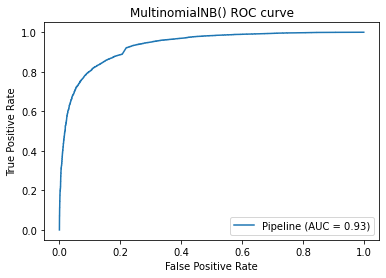

---------------------------------------------------------------------------------
########## Using LinearSVC() algorithm ##########

Total training time:  7.0625
Total testing time:  2.46875 

Confusion Matrix
[[ 5069  1436]
 [  847 12952]]

Classification report
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      6505
           1       0.90      0.94      0.92     13799

    accuracy                           0.89     20304
   macro avg       0.88      0.86      0.87     20304
weighted avg       0.89      0.89      0.89     20304


Overall accuracy: 0.8875591016548463
Precision: 0.900194606616625
Recall: 0.9386187404884412
F1-Score: 0.9190052151701139




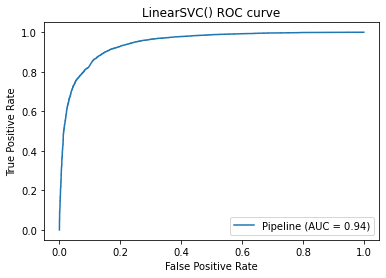

---------------------------------------------------------------------------------
########## Using RandomForestClassifier() algorithm ##########

Total training time:  319.46875
Total testing time:  5.96875 

Confusion Matrix
[[ 4421  2084]
 [  547 13252]]

Classification report
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      6505
           1       0.86      0.96      0.91     13799

    accuracy                           0.87     20304
   macro avg       0.88      0.82      0.84     20304
weighted avg       0.87      0.87      0.87     20304


Overall accuracy: 0.870419621749409
Precision: 0.8641105894627021
Recall: 0.960359446336691
F1-Score: 0.9096962416337738




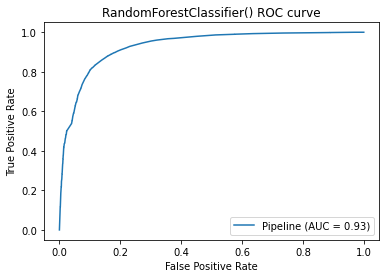

---------------------------------------------------------------------------------
########## Using GradientBoostingClassifier() algorithm ##########

Total training time:  146.59375
Total testing time:  2.5625 

Confusion Matrix
[[ 3914  2591]
 [  941 12858]]

Classification report
              precision    recall  f1-score   support

           0       0.81      0.60      0.69      6505
           1       0.83      0.93      0.88     13799

    accuracy                           0.83     20304
   macro avg       0.82      0.77      0.78     20304
weighted avg       0.82      0.83      0.82     20304


Overall accuracy: 0.8260441292356187
Precision: 0.8322868794096705
Recall: 0.9318066526559896
F1-Score: 0.8792396061269147




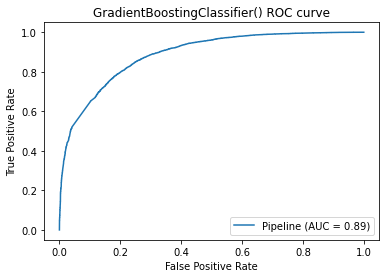

---------------------------------------------------------------------------------


In [26]:
text_nb, nb_metrics = model_training(X,y,MultinomialNB())
text_svm, svm_metrics = model_training(X,y,LinearSVC())
text_rf, rf_metrics = model_training(X,y,RandomForestClassifier())
text_gb, gb_metrics = model_training(X,y,GradientBoostingClassifier())

### Balance positive and negative reviews and re-train

In [27]:
reviews['ratings'].value_counts()

1    46294
0    21386
Name: ratings, dtype: int64

In [28]:
majority = reviews[reviews.ratings == 1]
minority = reviews[reviews.ratings == 0]

downsampled_majority = resample(majority,replace=False, n_samples=len(minority), random_state=77)

reviews_downsampled = pd.concat([downsampled_majority, minority])
 
reviews_downsampled['ratings'].value_counts()

0    21386
1    21386
Name: ratings, dtype: int64

In [29]:
X_downsampled = reviews_downsampled['reviews']
y_downsampled = reviews_downsampled['ratings']

########## Using MultinomialNB() algorithm ##########

Total training time:  4.140625
Total testing time:  1.578125 

Confusion Matrix
[[5683  720]
 [1255 5174]]

Classification report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      6403
           1       0.88      0.80      0.84      6429

    accuracy                           0.85     12832
   macro avg       0.85      0.85      0.85     12832
weighted avg       0.85      0.85      0.85     12832


Overall accuracy: 0.8460879052369077
Precision: 0.8778418730912793
Recall: 0.8047907917249961
F1-Score: 0.8397305850848009




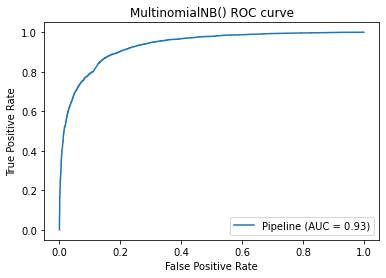

---------------------------------------------------------------------------------
########## Using LinearSVC() algorithm ##########

Total training time:  4.234375
Total testing time:  1.578125 

Confusion Matrix
[[5529  874]
 [ 745 5684]]

Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6403
           1       0.87      0.88      0.88      6429

    accuracy                           0.87     12832
   macro avg       0.87      0.87      0.87     12832
weighted avg       0.87      0.87      0.87     12832


Overall accuracy: 0.8738310473815462
Precision: 0.8667276608722171
Recall: 0.8841188365220096
F1-Score: 0.8753368753368752




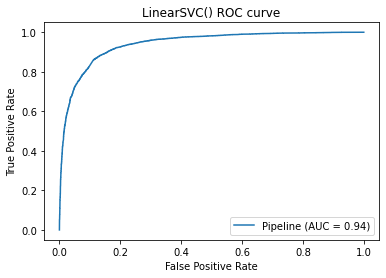

---------------------------------------------------------------------------------
########## Using RandomForestClassifier() algorithm ##########

Total training time:  182.4375
Total testing time:  3.03125 

Confusion Matrix
[[5657  746]
 [1281 5148]]

Classification report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      6403
           1       0.87      0.80      0.84      6429

    accuracy                           0.84     12832
   macro avg       0.84      0.84      0.84     12832
weighted avg       0.84      0.84      0.84     12832


Overall accuracy: 0.842035536159601
Precision: 0.8734306073973532
Recall: 0.8007466168922072
F1-Score: 0.8355108334009574




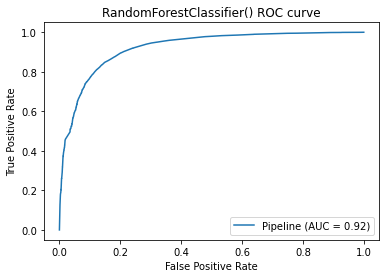

---------------------------------------------------------------------------------
########## Using GradientBoostingClassifier() algorithm ##########

Total training time:  87.5625
Total testing time:  1.296875 

Confusion Matrix
[[4977 1426]
 [1203 5226]]

Classification report
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      6403
           1       0.79      0.81      0.80      6429

    accuracy                           0.80     12832
   macro avg       0.80      0.80      0.80     12832
weighted avg       0.80      0.80      0.80     12832


Overall accuracy: 0.7951215710723192
Precision: 0.785628382441371
Recall: 0.8128791413905739
F1-Score: 0.7990214815381086




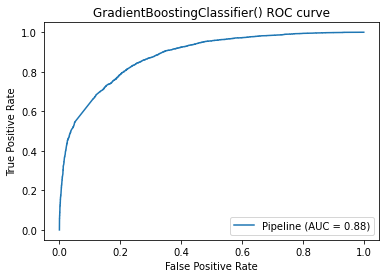

---------------------------------------------------------------------------------


In [30]:
text_nb_downsampled, nb_downsampled_metrics = model_training(X_downsampled,y_downsampled,MultinomialNB())
text_svm_downsampled, svm_downsampled_metrics = model_training(X_downsampled,y_downsampled,LinearSVC())
text_rf_downsampled, rf_downsampled_metrics = model_training(X_downsampled,y_downsampled,RandomForestClassifier())
text_gb_downsampled, gb_downsampled_metrics = model_training(X_downsampled,y_downsampled,GradientBoostingClassifier())

In [31]:
learners = {'Naive Bayes':text_nb, 
            'Naive Bayes (Downsampled)':text_nb_downsampled,
            'SVM':text_svm,
            'SVM (Downsampled)':text_svm_downsampled,
            'Random Forest':text_rf,
            'Random Forest (Downsampled)':text_rf_downsampled,
            'Gradient Boosting':text_gb,
            'Gradient Boosting (Downsampled)':text_gb_downsampled
           }
metrics_dict = {'Naive Bayes':nb_metrics, 
            'Naive Bayes (Downsampled)':nb_downsampled_metrics,
            'SVM':svm_metrics,
            'SVM (Downsampled)':svm_downsampled_metrics,
            'Random Forest':rf_metrics,
            'Random Forest (Downsampled)':rf_downsampled_metrics,
            'Gradient Boosting':gb_metrics,
            'Gradient Boosting (Downsampled)':gb_downsampled_metrics
           }

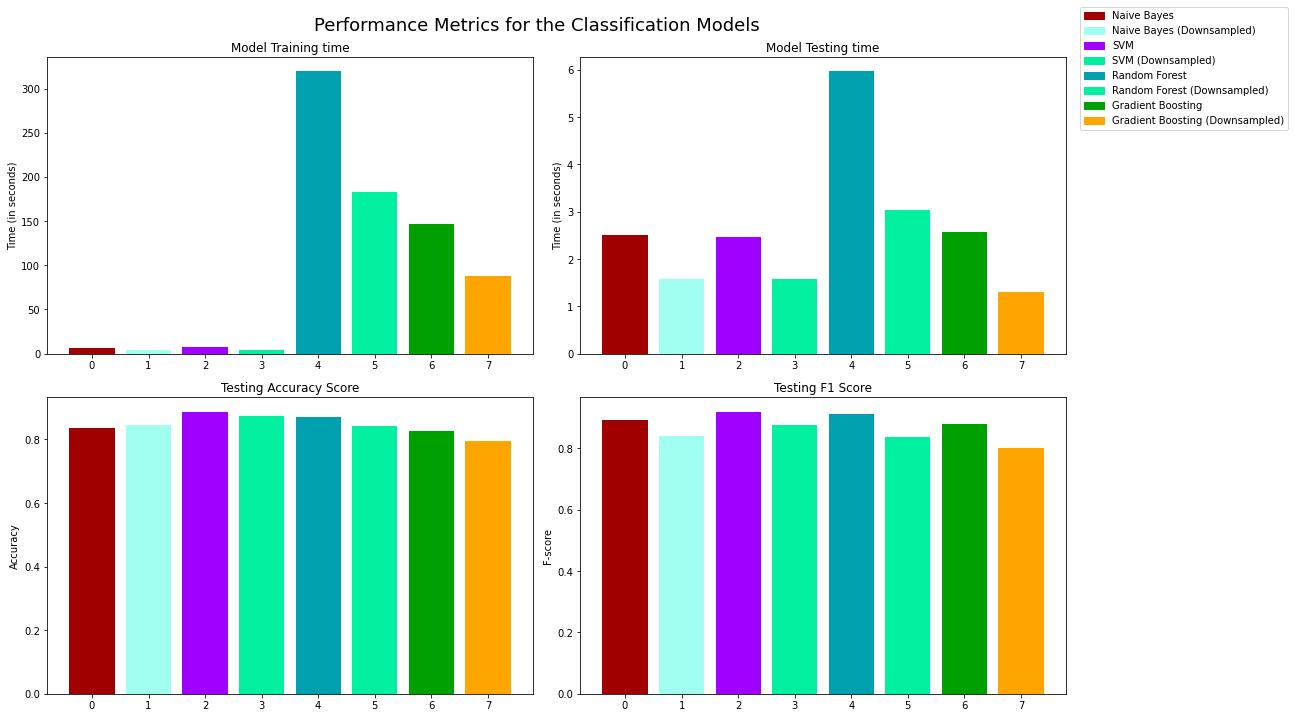

In [32]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))
colors = ['#A00000','#A0FFF1','#A000FF','#00F0A0',
          '#00A0AF','#00F0A0','#00A000','#FFA500',
          '#BFA500','#DFA500','#FFF500','#FFAFF0']

for k, learner in enumerate(learners.keys()):
    for j, metric in enumerate(['Total training time','Total testing time','Accuracy','F1 Score']):
        ax[j//2, j%2].bar(k, metrics_dict[learner][metric],color = colors[k])
            
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 0].set_title("Model Training time")

ax[0, 1].set_ylabel("Time (in seconds)")
ax[0, 1].set_title("Model Testing time")

ax[1, 0].set_ylabel("Accuracy")
ax[1, 0].set_title("Testing Accuracy Score")

ax[1, 1].set_ylabel("F-score")
ax[1, 1].set_title("Testing F1 Score")


patches = []
for i, learner in enumerate(learners.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
fig.legend(handles = patches, loc='upper center', bbox_to_anchor=(1.1, 1), ncol = 1, fontsize = 'medium')

plt.suptitle("Performance Metrics for the Classification Models", fontsize = 18)
plt.tight_layout()
plt.show()

#### Check prediction in reviews from https://www.skroutz.gr

In [33]:
def data_extraction(url,reviews_selector,ratings_selector):
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    reviews = soup.select(reviews_selector)
    ratings = soup.select(ratings_selector)
    rlist = []
    for i in range(len(reviews)):
        rlist.append([reviews[i].text,ratings[i].text])
    data = pd.DataFrame(rlist,columns=['reviews','sentiment'])
    sentiment_dict = {'1':0, '2':0, '3':0, '4':1, '5':1}
    data['sentiment'].replace(sentiment_dict,inplace=True)
    data['reviews'] = data['reviews'].apply(clean_text)
    return data

In [34]:
url = 'https://www.skroutz.gr/s/20060269/Apple-iPhone-11-64GB-Black.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)
predictions = text_svm.predict(data['reviews'])
confidence = text_svm.decision_function(data['reviews'])
for i in range(len(predictions)):
    print('For label ',data['sentiment'][i],' Classifier predicted ',predictions[i],
      ' with confidence',confidence[i])
print(metrics.classification_report(data['sentiment'],text_svm.predict(data['reviews'])))
print(metrics.confusion_matrix(data['sentiment'],text_svm.predict(data['reviews'])))

For label  1  Classifier predicted  1  with confidence 1.345630337429905
For label  1  Classifier predicted  0  with confidence -0.004008568227370668
For label  1  Classifier predicted  1  with confidence 0.6888819830921226
For label  0  Classifier predicted  1  with confidence 0.21618616459035034
For label  0  Classifier predicted  1  with confidence 0.3945029786548444
For label  1  Classifier predicted  0  with confidence -0.05820711734958345
For label  1  Classifier predicted  1  with confidence 0.8018993462257371
For label  1  Classifier predicted  1  with confidence 1.6592122139645424
For label  1  Classifier predicted  1  with confidence 1.4631632429253931
For label  1  Classifier predicted  1  with confidence 2.375498478510345
For label  1  Classifier predicted  1  with confidence 0.2882315546871539
For label  1  Classifier predicted  1  with confidence 0.47752413765079504
For label  1  Classifier predicted  1  with confidence 0.3026860401114925
For label  1  Classifier predicte

In [35]:
url = 'https://www.skroutz.gr/s/23120421/Samsung-Galaxy-A20e-Dual-32GB-Coral.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)
print(metrics.classification_report(data['sentiment'],text_svm.predict(data['reviews'])))
print(metrics.confusion_matrix(data['sentiment'],text_svm.predict(data['reviews'])))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.76      0.76      0.76        21

    accuracy                           0.67        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.67      0.67      0.67        30

[[ 4  5]
 [ 5 16]]


In [36]:
url = 'https://www.skroutz.gr/s/12247000/Gigabyte-GeForce-GT-1030-2GB-OC-GV-N1030OC-2GI.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)
print(metrics.classification_report(data['sentiment'],text_svm.predict(data['reviews'])))
print(metrics.confusion_matrix(data['sentiment'],text_svm.predict(data['reviews'])))

              precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.96      0.82      0.88        28

    accuracy                           0.80        30
   macro avg       0.56      0.66      0.57        30
weighted avg       0.91      0.80      0.84        30

[[ 1  1]
 [ 5 23]]


In [37]:
url = 'https://www.skroutz.gr/s/5281582/Adidas-Stan-Smith-M20325.html#reviews'
rselector= '#sku_reviews_list > li div.review-body'
sselector = '#sku_reviews_list > li div.actual-rating > span'
data = data_extraction(url,rselector,sselector)
print(metrics.classification_report(data['sentiment'],text_svm.predict(data['reviews'])))
print(metrics.confusion_matrix(data['sentiment'],text_svm.predict(data['reviews'])))

              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.86      0.79      0.83        24

    accuracy                           0.73        30
   macro avg       0.62      0.65      0.63        30
weighted avg       0.77      0.73      0.75        30

[[ 3  3]
 [ 5 19]]
